<Figure size 3600x1500 with 0 Axes>

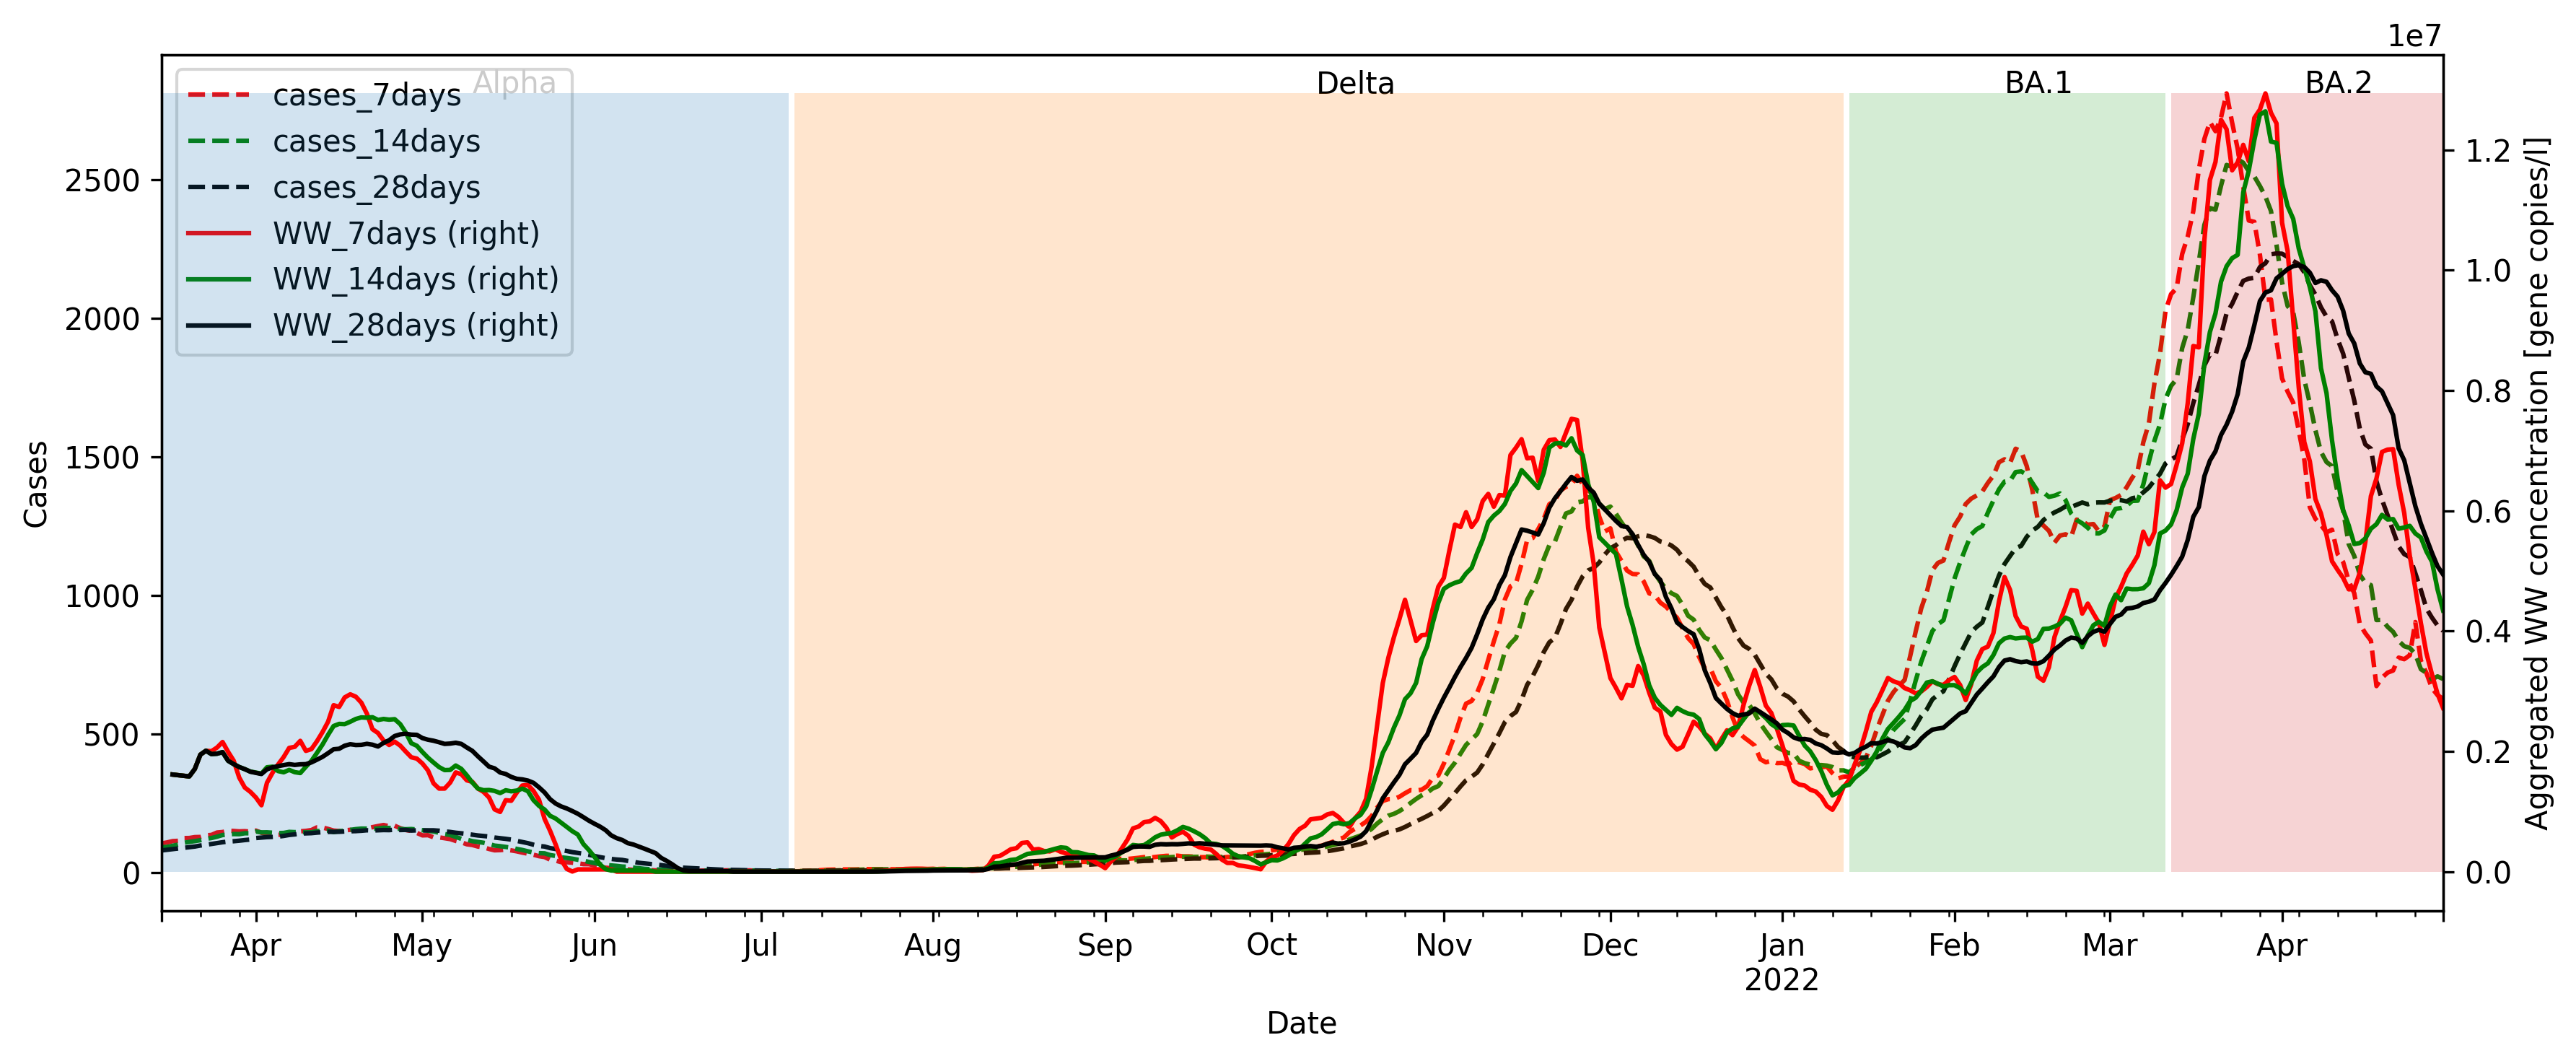

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12.0, 5.0]
mpl.rcParams['figure.dpi'] = 300

abw = pd.read_csv("Wastewater_DD.csv", parse_dates=True
).rename(columns={"Abwasser Täglich": "daily", "__timestamp": "Date"}).set_index("Date").filter(("daily",)).loc["2021-03-15":]
abw.index = pd.to_datetime(abw.index)
abw.index = abw.index.strftime("%Y-%m-%d")

wet = pd.read_csv("Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))

# rki
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
rki.rename(columns={"rki_7days": "cases_7days", "rki_14days": "cases_14days", "rki_28days": "cases_28days"}, inplace=True)

# join
df = abw.join(rki).join(wet)
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")

# handle precipitation
df[f"daily"] = df.loc[df.prcp < 5, f"daily"]
# df["daily"] = df["daily"].interpolate("time", axis=0)
df = df.interpolate("time", axis=0)
df["WW_7days"] = df["daily"].rolling(7, min_periods=1, closed="left").mean() * 7
df["WW_14days"] = df["daily"].rolling(14, min_periods=1, closed="left").mean() * 7
df["WW_28days"] = df["daily"].rolling(28, min_periods=1, closed="left").mean() * 7
df.drop(columns=["daily", "prcp"], inplace=True)

# truncate
df = df.loc[:"2022-04-30"]

# varianten
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
# var = var.filter(("Alpha", "Delta", "Omicron"))
var = var.filter(("Alpha", "Delta", "BA.1", "BA.2"))
var.index = pd.to_datetime(var.index)
var = var.reindex(df.index)
var = var.interpolate("time", axis=0)
variants = {k: var.idxmax(axis=1)==k for k in var}
# var.plot()
plt.tight_layout()

# plot
style = {f"cases_{k}days": c + "--" for c, k in zip(("r", "g", "k"), (7, 14, 28))}
style.update({f"WW_{k}days": c + "-" for c, k in zip(("r", "g", "k"), (7, 14, 28))})
# style.update({k: "r" for k in ("sum_7days", "sum_14days", "sum_28days", "daily")})
ax = df.filter(regex="cases").plot(style=style)
plt.ylabel("Cases")
df.filter(regex="WW").plot(secondary_y=("WW_7days", "WW_14days", "WW_28days"), style=style, ax=ax)
plt.ylabel("Aggregated WW concentration [gene copies/l]")
for vv, v in variants.items():
    plt.fill_betweenx([0, max(df.max())], df.loc[v].index[0], df.loc[v].index[-1], alpha=0.2)
    ax.text(df.loc[v].index.mean(), max(df.filter(regex="cases").max()), vv)
plt.tight_layout()
# ax.ylabel("cases")
# ax2.ylabel("WW concentration")
# plt.savefig("verlauf.svg")
plt.savefig("verlauf.png")
plt.show()

# px.line(df)
# px.line(df/df.max())
# px.line(df, log_y=True)
# variants


# Functions

In [2]:
def correlate(x, y, w):
    import numpy as np

    def m(x, w):
        """Weighted Mean"""
        return np.nansum(x * w) / np.nansum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.nansum(w * (x - m(x, w)) * (y - m(y, w))) / np.nansum(w)

    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


def get_lag(left, right, weights=None, method="pearson"):
    rng = range(-12, 12)
    if weights is None:
        rs = [right.corr(left.shift(lag)) for lag in rng]
    else:
        rs = [correlate(right.values, left.shift(lag).values, weights) for lag in rng]
    # rs = [right.corr(left.shift(lag), method=method) for lag in rng]
    rs = pd.DataFrame(rs, index=rng)
    return rs.idxmax()[0]


def shift(df, day, weights=None, dropna=False):
    lag = get_lag(df[f"cases_{day}days"], df[f"WW_{day}days"], weights)
    df[f"cases_{day}days"] = df[f"cases_{day}days"].shift(lag)
    if dropna:
        df.dropna(inplace=True)
    return df, lag


def shift_v2(df, left, right, weights=None, dropna=False):
    lag = get_lag(df[left], df[right], weights)
    df[left] = df[left].shift(lag)
    if dropna:
        df.dropna(inplace=True)
    return df, lag


# Linear regression
def get_lin_model(left, right, v=None):
    c, i = get_lin_coeff(left, right, v)
    return left * c + i


def get_lin_coeff(left, right, v=None):
    X = left.to_numpy().reshape(-1, 1)
    y = right.to_numpy().reshape(-1, 1)
    if v is None:
        reg = LinearRegression().fit(X, y)
    else:
        reg = LinearRegression().fit(X, y, sample_weight=v.loc[left.index])
    return reg.coef_[0][0], reg.intercept_[0]


def get_mse(left, right, v):
    # weighted mean squared error
    w = v.loc[left.index]
    d = ((left - right)).pow(2)
    return (d * w).sum() / w.sum()
    # return d.mean()


def get_mre(left, right, v):
    # weighted mean relative error
    w = v.loc[left.index]
    d = ((left - right) / left).abs()
    return (d * w).sum() / w.sum()


def get_corr(left, right, v):
    # weighted correlation
    w = v.loc[left.index]
    return correlate(left.values, right.values, w)


def rmse(left, right):
    # root mean squared error
    return np.sqrt(np.mean(np.square(left - right)))
    

def autoscale_df(df):
    return (df - df.min()) / (df.max() - df.min())
    
def get_wave_idx(df, wave):
    return df.where(variants[wave]).dropna(how="all").index



# Correlation

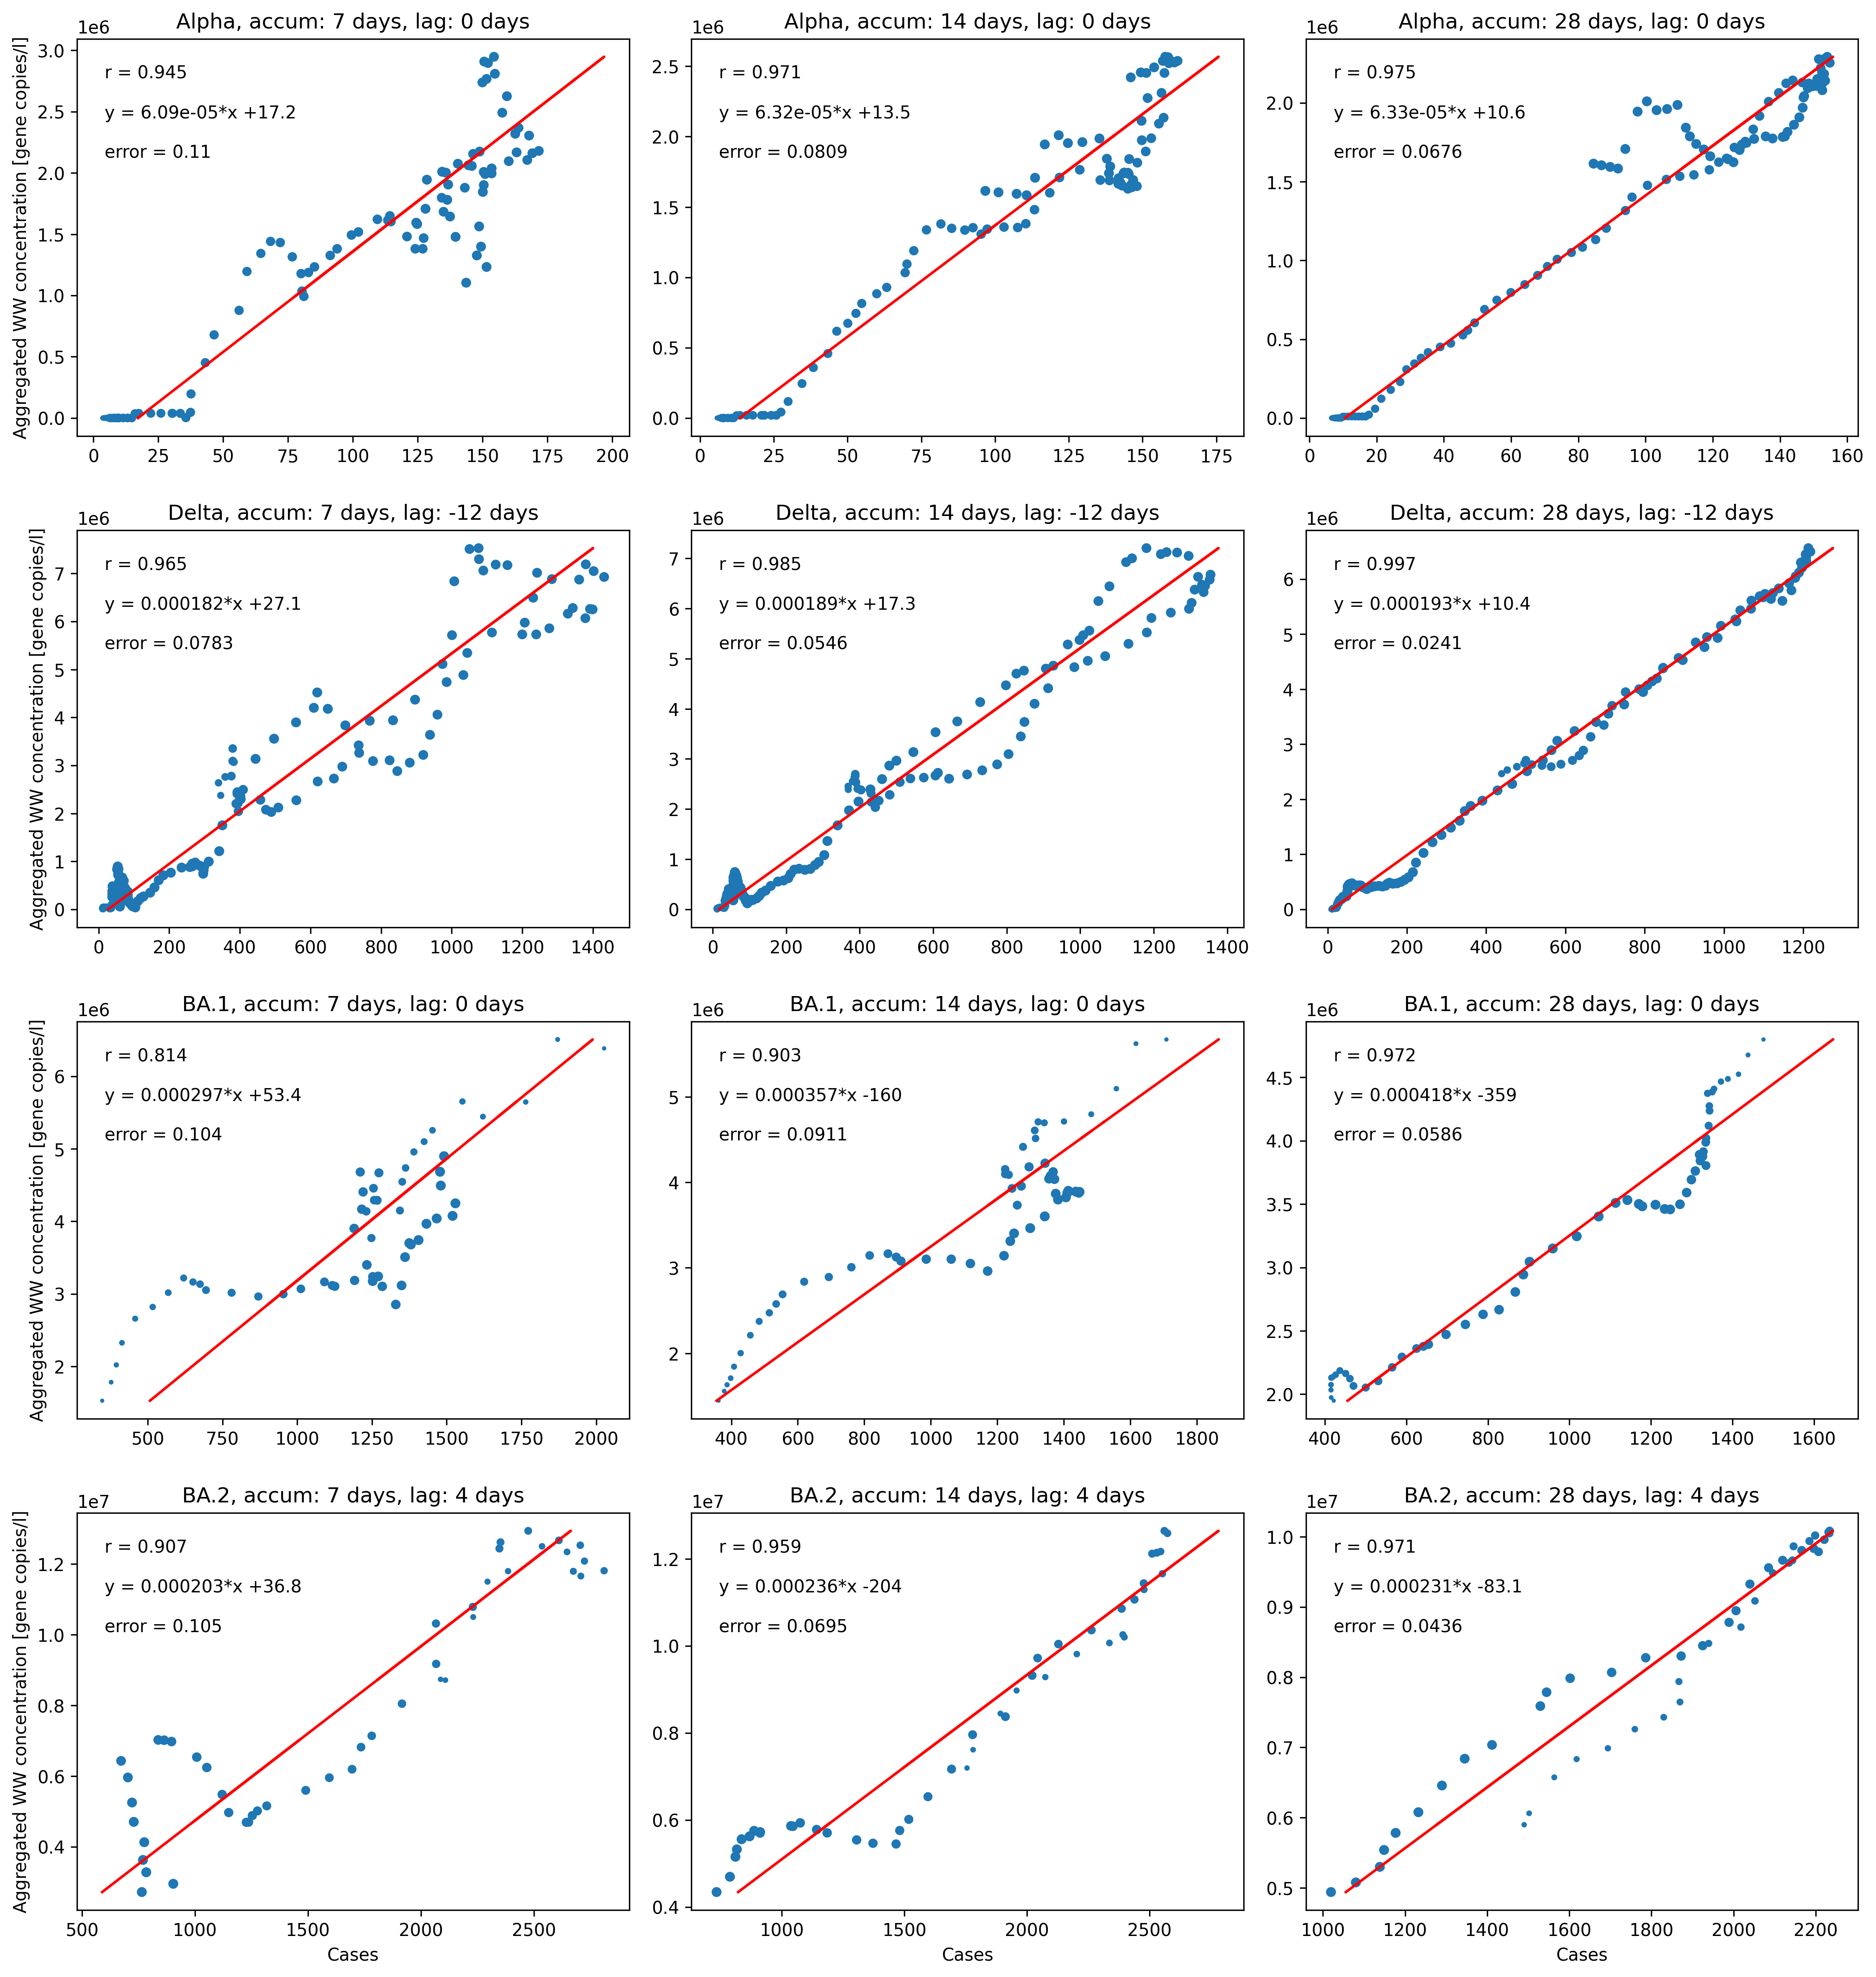

overall r: [0.9313106524083322, 0.9663821821897609, 0.9844943074583922]
overall err: [0.09387148159130317, 0.0688519132677783, 0.04337899492009683]


In [8]:
df_total = pd.DataFrame()
fig, axis = plt.subplots(
    len(variants), 3, figsize=(15, 4 * len(variants))  # , sharex=True, sharey=True
)
ci = {}
overall_r = [0] * 3
overall_err = [0] * 3
overall_len = [0] * 3
error = {}
for w, v in enumerate(variants):
    df_shifted = df.loc[variants[v]].copy()
    ci[v] = {}
    error[v] = {}
    for i, k in enumerate((7, 14, 28)):
        ax = axis[w, i]
        df_shifted, lag = shift(df_shifted, k, var[v].loc[df_shifted.index])
        df_shifted.plot.scatter(
            f"cases_{k}days",
            f"WW_{k}days",
            title=f"{v}, accum: {k} days, lag: {lag} days",
            ax=ax,
            ylabel="",
            xlabel="",
            s=autoscale_df(var[v].loc[df_shifted.index]) * 20 + 2,
        )
        df_tmp = df_shifted.filter((f"cases_{k}days", f"WW_{k}days")).dropna()
        df_shifted[f"pred_{k}"] = get_lin_model(
            df_tmp[f"WW_{k}days"], df_tmp[f"cases_{k}days"], var[v]
        )
        ci[v][k] = get_lin_coeff(df_tmp[f"WW_{k}days"], df_tmp[f"cases_{k}days"], var[v])
        df_shifted.plot.line(
            f"pred_{k}",
            f"WW_{k}days",
            ax=ax,
            legend=False,
            color="r",
            ylabel="",
            xlabel="",
        )

        # annotate error
        r = get_corr(df_shifted[f"pred_{k}"], df_shifted[f"cases_{k}days"], var[v])
        error[v][k] = np.sqrt(np.mean(np.square(df_shifted[f"pred_{k}"] - df_shifted[f"cases_{k}days"]))) / df_shifted[f"cases_{k}days"].max()
        # ax.annotate(
        #     f"r: {r:.3f}",
        #     (df_shifted[f"pred_{k}"].mean(), df_shifted[f"WW_{k}days"].mean()),
        #     xytext=(40, 0),
        #     textcoords="offset points",
        #     color="r",
        # ).set(fontweight="semibold")
        ax.text(0.05, 0.9, f"r = {r:.3f}", transform=ax.transAxes)
        ax.text(0.05, 0.8, f"y = {ci[v][k][0]:.3g}*x {ci[v][k][1]:+.3g}", transform=ax.transAxes)
        ax.text(0.05, 0.7, f"error = {error[v][k]:.3g}", transform=ax.transAxes)


        # calculate overall r
        overall_r[i] += r * len(df_shifted)
        overall_err[i] += error[v][k] * len(df_shifted)
        overall_len[i] += len(df_shifted)

    df_total = pd.concat([df_total, df_shifted.copy()])

# set labels
plt.setp(axis[-1, :], xlabel='Cases')
plt.setp(axis[:, 0], ylabel='Aggregated WW concentration [gene copies/l]')
plt.tight_layout()
plt.savefig("correlation.svg")
plt.savefig("correlation.png")
plt.show()

# overall error
print("overall r:", [r / l for r, l in zip(overall_r, overall_len)])
print("overall err:", [r / l for r, l in zip(overall_err, overall_len)])
# print(f"errors: {pd.DataFrame(error).transpose()}")


# error investigation

In [9]:
# get composite models
from collections import OrderedDict
ci_err = OrderedDict()
dfs = OrderedDict()
cumulative_error = False
k = 14
df_tmp = df.filter(regex=f"{k}days").rename(columns={f"cases_{k}days": "cases", f"WW_{k}days": "WW"})
df_tmp = df_tmp / df_tmp.max()
# df_plot = df_tmp

# correlate per variant/wave
for i, v in enumerate(variants):
    # individual
    df_indiv = df_tmp.loc[variants[v]].copy()
    df_indiv, lag = shift_v2(df_indiv, "cases", "WW", var[v].loc[df_indiv.index], dropna=True)
    ci_err[v] = get_lin_coeff(df_indiv["WW"], df_indiv["cases"], var[v])
    dfs[v] = df_indiv.copy()

    # df_plot = pd.concat([df_plot, df_indiv["WW"]])
    # df_plot[f"cases_{v}"] = df_indiv["cases"]
    
    # composite
    if i > 0:
        last_idx = df_tmp.loc[variants[v]].last_valid_index()
        df_cum = df_tmp.loc[:last_idx].copy()
        df_cum, lag = shift_v2(df_cum, "cases", "WW", dropna=True)
        ci_err[f"{v}_cum"] = get_lin_coeff(df_cum["WW"], df_cum["cases"], var[v])

print(ci_err)

# calculate metrics
error = {c: {} for c in ci_err}
pearson = {c: {} for c in ci_err}
for c in ci_err:
    for v in variants:
        pred = dfs[v]["WW"] * ci_err[c][0] + ci_err[c][1]
        
        # Errors
        err = rmse(pred, dfs[v]["cases"])
        if len(error[c]) == 0 or not cumulative_error:
            error[c][v] = err
        else:
            # print([error[c][d] * len(d) for _, d in zip(error[c], dfs)])
            error[c][v] = np.sum([error[c][d] * len(d) for _, d in zip(error[c], dfs)]) + (err * len(pred))
            error[c][v] /= np.sum([len(dfs[d]) for _, d in zip(error[c], dfs)])

        # Pearson
        r = pred.corr(dfs[v]["cases"])
        if len(pearson[c]) == 0 or not cumulative_error:
            pearson[c][v] = r
        else:
            pearson[c][v] = np.sum([pearson[c][d] * len(d) for _, d in zip(pearson[c], dfs)]) + (r * len(pred))
            pearson[c][v] /= np.sum([len(dfs[d]) for _, d in zip(pearson[c], dfs)])

        # df_plot[f"pred_{c}_{v}"] = pred
# df_plot.plot(legend=False)

pd.options.display.float_format = '{:,.3f}'.format
# pd.concat([pd.DataFrame(error), pd.DataFrame(pearson)])
pd.DataFrame(pearson)

OrderedDict([('Alpha', (0.3103041756623307, 0.005246098650119307)), ('Delta', (0.9262828648989302, 0.006702772890781444)), ('Delta_cum', (0.9297584879199472, 0.0030836931725835848)), ('BA.1', (1.754429407104536, -0.06229799498978089)), ('BA.1_cum', (1.6660580148078328, -0.0066523729980970114)), ('BA.2', (1.1601412336482675, -0.07917821707532069)), ('BA.2_cum', (0.9340195112441997, 0.08201202899607718))])


,Alpha,Delta,Delta_cum,BA.1,BA.1_cum,BA.2,BA.2_cum
Alpha,0.975,0.975,0.975,0.975,0.975,0.975,0.975
Delta,0.985,0.985,0.985,0.985,0.985,0.985,0.985
BA.1,0.912,0.912,0.912,0.912,0.912,0.912,0.912
BA.2,0.959,0.959,0.959,0.959,0.959,0.959,0.959


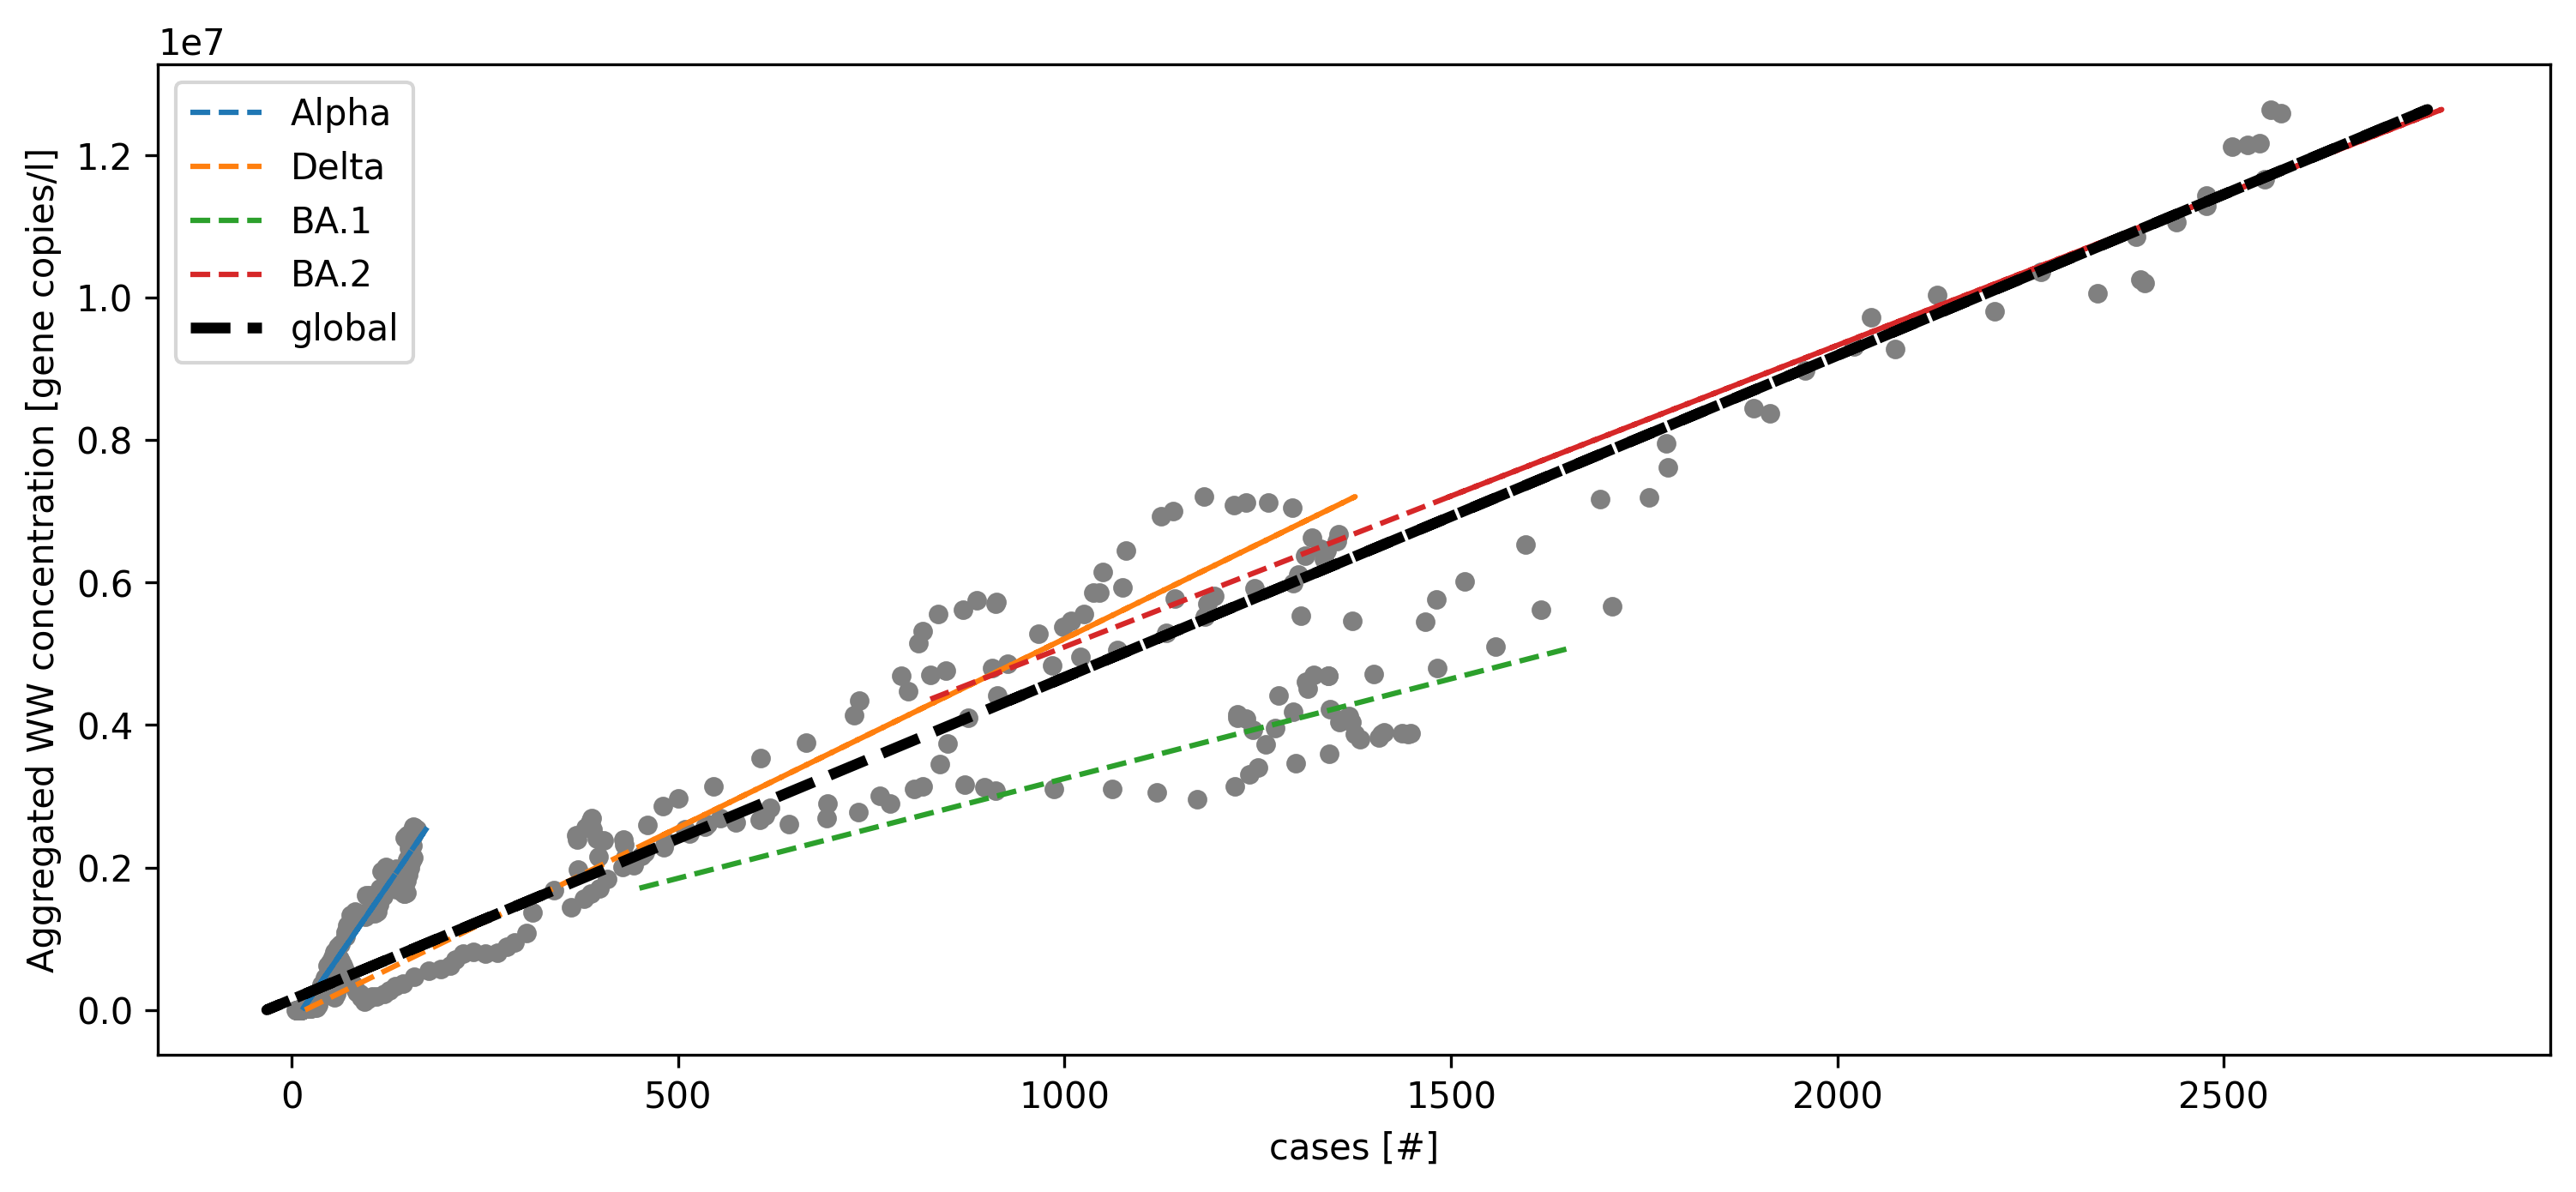

In [5]:
k = 14
ax = df_total.plot.scatter(f"cases_{k}days", f"WW_{k}days", color="gray")
# individual models
for v in variants:
    df_total[f"{v}"] = df_total[f"WW_{k}days"].where(var[v] > 0.5)
    df_total.plot.line(f"pred_{k}", f"{v}", ax=ax, style="--")
    # df_total.where(var[v] > 0.5).plot.line(f"pred_{k}", f"WW_{k}days", ax=ax, style="--", linewidth=3)#, legend=False)
# df_total.filter(regex=f"WW_{k}days_").plot.line(ax=ax, color="r", style="--")
# total model
df_tmp = df_total.filter((f"WW_{k}days", f"cases_{k}days")).dropna()
c_sum, i_sum = get_lin_coeff(
    df_tmp[f"WW_{k}days"], df_tmp[f"cases_{k}days"]
)
df_total[f"pred_sum"] = df_total[f"WW_{k}days"] * c_sum + i_sum
df_total[f"global"] = df_total[f"WW_{k}days"]
df_total.plot.line(
    f"pred_sum", f"global", ax=ax, color="k", style="--", linewidth=3#, legend=False
)
plt.xlabel("cases [#]")
plt.ylabel("Aggregated WW concentration [gene copies/l]")
# plt.legend()
# plt.title(f"Linear Regression {k} days")
# plt.savefig("correlation_total.svg")
plt.savefig("correlation_total.png")
plt.show()


In [10]:
from pprint import pprint as pp
pp(ci_err)
print("total:", c_sum, i_sum)

OrderedDict([('Alpha', (0.3103041756623307, 0.005246098650119307)),
             ('Delta', (0.9262828648989302, 0.006702772890781444)),
             ('Delta_cum', (0.9297584879199472, 0.0030836931725835848)),
             ('BA.1', (1.754429407104536, -0.06229799498978089)),
             ('BA.1_cum', (1.6660580148078328, -0.0066523729980970114)),
             ('BA.2', (1.1601412336482675, -0.07917821707532069)),
             ('BA.2_cum', (0.9340195112441997, 0.08201202899607718))])
total: 0.00022121078740079848 -32.355416968337295


# results

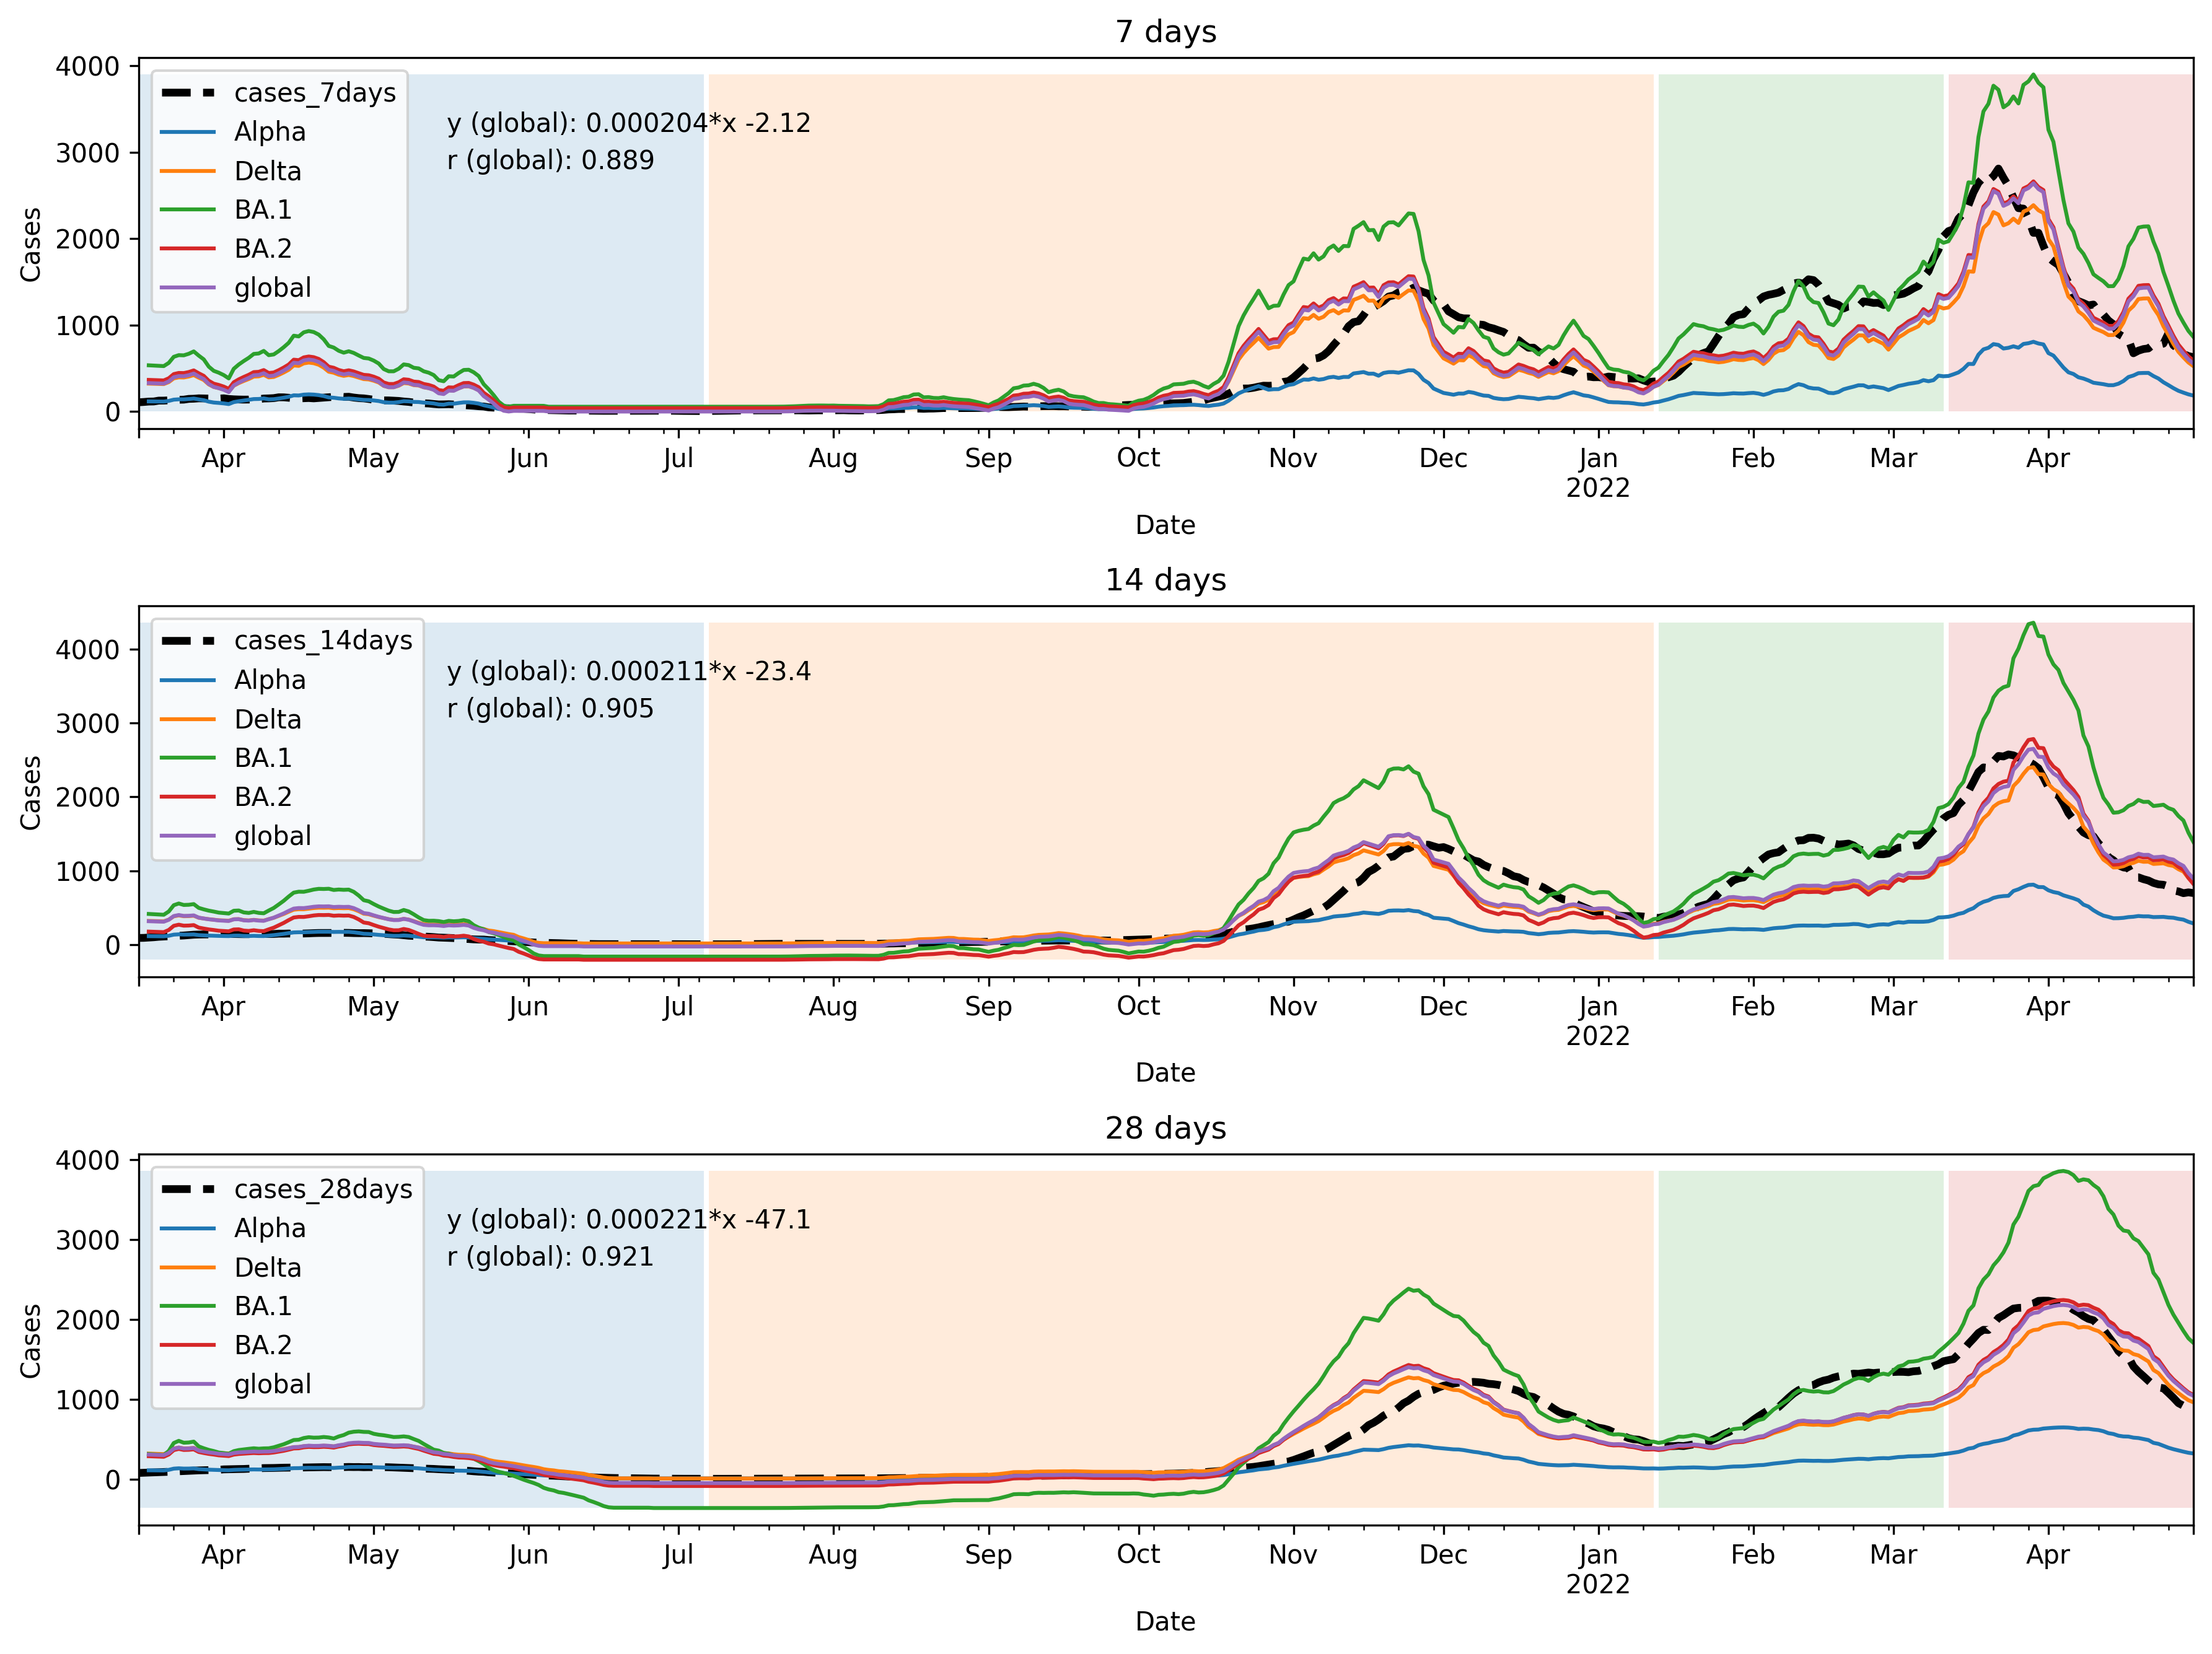

In [11]:
# total prediction
fig, axis = plt.subplots(3, 1, figsize=(12, 9), dpi=300)
for ii, k in enumerate((7, 14, 28)):
    style = {f"cases_{k}days": "k--"}
    df_pred = df.filter(regex=f"{k}days").copy()
    df_pred.interpolate("time", axis=0, inplace=True)
    for v in ci:
        df_pred[v] = df_pred[f"WW_{k}days"] * ci[v][k][0] + ci[v][k][1]
    c_sum, i_sum = get_lin_coeff(df_pred.dropna()[f"WW_{k}days"], df_pred.dropna()[f"cases_{k}days"])
    df_pred["global"] = df_pred[f"WW_{k}days"] * c_sum + i_sum
    df_pred.filter(regex=f"cases_{k}").plot(title=f"{k} days", ax=axis[ii], ylabel="Cases", style=style, linewidth=3)
    df_pred.filter(regex="^(?!WW|cases)").plot(title=f"{k} days", ax=axis[ii], ylabel="Cases")
    r_global = df_pred[f"cases_{k}days"].corr(df_pred["global"])
    axis[ii].text(0.15, 0.8, f"y (global): {c_sum:.3g}*x {i_sum:+.3g}", transform=axis[ii].transAxes)
    axis[ii].text(0.15, 0.7, f"r (global): {r_global:.3g}", transform=axis[ii].transAxes)
    for vv, v in variants.items():
        min_max_y = [min(df_pred.filter(regex="^(?!WW)").min()), max(df_pred.filter(regex="^(?!WW)").max())]
        axis[ii].fill_betweenx(min_max_y, df.loc[v].index[0], df.loc[v].index[-1], alpha=0.15)
        # axis[ii].text(df.loc[v].index.mean(), min_max_y[1], vv)
plt.tight_layout()
# plt.savefig("prediction.svg")
plt.savefig("prediction.png")
plt.show()


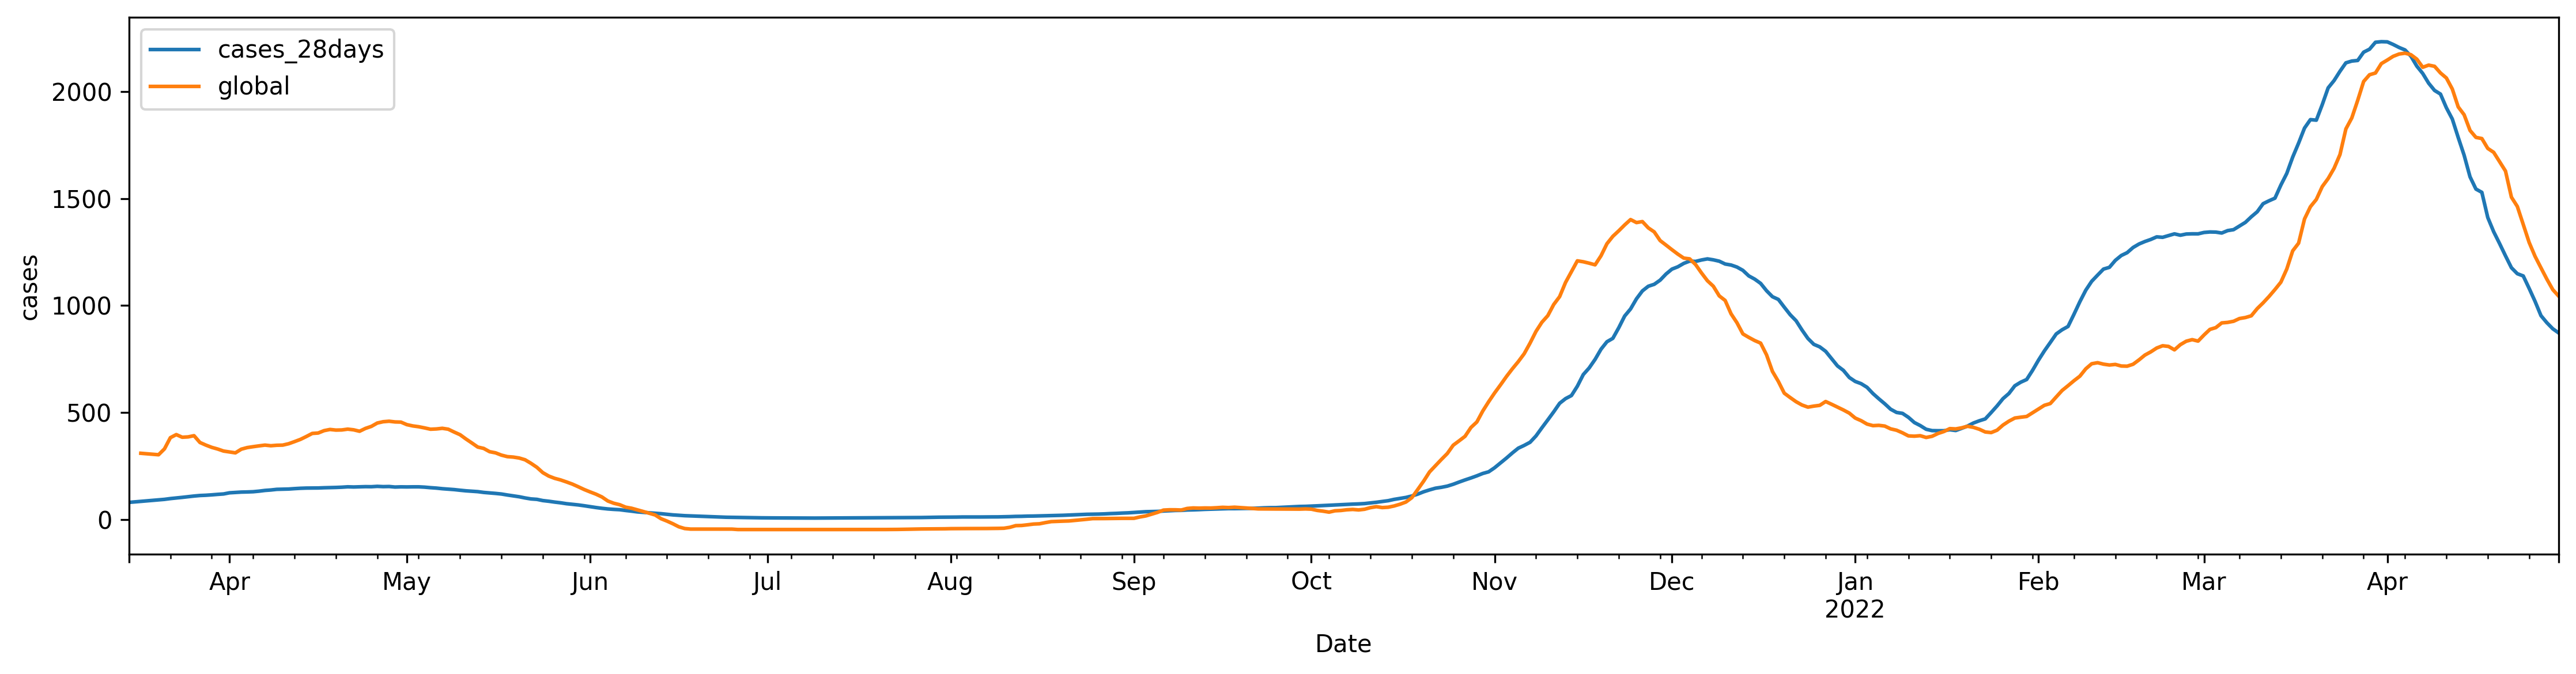

In [15]:
# global model
k = 28
df_tmp = df.filter((f"cases_{k}days", f"WW_{k}days",)).copy()
df_tmp[f"global_model"] = df_tmp[f"WW_{k}days"] * c_sum + i_sum
df_tmp.filter((f"cases_{k}days", "global_model")).plot.line(figsize=(15, 4), ylabel="cases")
plt.tight_layout()
plt.savefig("prediction_onemodel.png")
plt.show()